In [39]:
import requests
from IPython.display import Markdown
from tqdm import tqdm, tqdm_notebook
import pandas as pd
from matplotlib import pyplot as plt
import altair as alt
from requests.utils import quote
import os
from github import Github

In [2]:
end_date = "2019-06-01"
start_date = "2019-05-01"
renderer = "jupyterlab"

In [3]:
# Create the renderer we want
alt.renderers.enable(renderer)

RendererRegistry.enable('jupyterlab')

In [4]:
# Discourse API key
api = {'Api-Key': os.environ['DISCOURSE_API_KEY'],
       'Api-Username': os.environ['DISCOURSE_API_USERNAME']}

In [65]:
# Discourse
def topics_to_markdown(topics, n_list=10):
    body = []
    for _, topic in topics.iterrows():
        title = topic['fancy_title']
        slug = topic['slug']
        posts_count = topic['posts_count']
        url = f'https://discourse.jupyter.org/t/{slug}'
        body.append(f'* [{title}]({url}) ({posts_count} posts)')
    body = body[:n_list]
    return '\n'.join(body)

def counts_from_activity(activity):
    counts = activity.groupby('category_id').count()['bookmarked'].reset_index()
    counts['parent_category'] = None
    for ii, irow in counts.iterrows():
        if parent_categories[irow['category_id']] is not None:
            counts.loc[ii, 'parent_category'] = parent_categories[irow['category_id']]

    counts['category_id'] = counts['category_id'].map(lambda a: category_mapping[a])
    counts['parent_category'] = counts['parent_category'].map(lambda a: category_mapping[a] if a is not None else 'parent')
    is_parent = counts['parent_category'] == 'parent'
    counts.loc[is_parent, 'parent_category'] = counts.loc[is_parent, 'category_id'] 
    counts['parent/category'] = counts.apply(lambda a: a['parent_category']+'/'+a['category_id'], axis=1)
    counts = counts.sort_values(['parent_category', 'bookmarked'], ascending=False)
    return counts

# GitHub
def run_github_query(query, github_base="https://api.github.com/search/issues"):
    gh = Github(os.environ["GITHUB_ACCESS_TOKEN"])
    resp = gh.search_issues(query)
    data = []
    for ii in range(0, 10):
        items = resp.get_page(ii)
        if len(items) > 0:
            items_list = [item.raw_data for item in items]
            data.append(pd.DataFrame.from_records(items_list))
        else:
            break
    return pd.concat(data)


# Community forum activity

The [Jupyter Community Forum](https://discourse.jupyter.org) is a place for Jovyans across the
community to talk about Jupyter tools in interactive computing and how they fit into their
workflows. It's also a place for developers to share ideas, tools, tips, and help one another.

Below are a few updates from activity in the Discourse. For more detailed information about
the activity on the Community Forum, check out these links:

* [The users page](https://discourse.jupyter.org/u) has information about user activity
* [The top posts page](https://discourse.jupyter.org/top) contains a list of top posts, sorted
  by various metrics.

In [6]:
# Get categories for IDs
url = "https://discourse.jupyter.org/site.json"
resp = requests.get(url, headers=api)
category_mapping = {cat['id']: cat['name'] for cat in resp.json()['categories']}
parent_categories = {cat['id']: cat.get("parent_category_id", None) for cat in resp.json()['categories']}

In [7]:
# Base URL to use
url = "https://discourse.jupyter.org/latest.json"

## Topics with lots of likes

"Likes" are a way for community members to say thanks for a helpful post, show their
support for an idea, or generally to share a little positivity with somebody else.
These are topics that have generated lots of likes in recent history.

In [8]:
params = {"order": "likes", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Topics with the most likes in recent history
liked = pd.DataFrame(resp.json()['topic_list']['topics'])
Markdown(topics_to_markdown(liked))

* [Introduce yourself!](https://discourse.jupyter.org/t/introduce-yourself) (93 posts)
* [{WIP} Re-Design of Jupyter.org Website](https://discourse.jupyter.org/t/wip-re-design-of-jupyter-org-website) (29 posts)
* [Jupyter Community Calls](https://discourse.jupyter.org/t/jupyter-community-calls) (23 posts)
* [Help us choose an updated &ldquo;Launch Binder&rdquo; badge!](https://discourse.jupyter.org/t/help-us-choose-an-updated-launch-binder-badge) (21 posts)
* [PyCon 2019 and mybinder.org](https://discourse.jupyter.org/t/pycon-2019-and-mybinder-org) (17 posts)
* [Jupyter community workshop: proposal on diversity, inclusion and accessibility](https://discourse.jupyter.org/t/jupyter-community-workshop-proposal-on-diversity-inclusion-and-accessibility) (20 posts)
* [The Binder Federation](https://discourse.jupyter.org/t/the-binder-federation) (13 posts)
* [Sunset the GitHub repo jupyter/help?](https://discourse.jupyter.org/t/sunset-the-github-repo-jupyter-help) (17 posts)
* [Binder/BinderHub Workshops &ndash; Help Wanted!](https://discourse.jupyter.org/t/binder-binderhub-workshops-help-wanted) (25 posts)
* [Creating a new Binder-at-home tool](https://discourse.jupyter.org/t/creating-a-new-binder-at-home-tool) (13 posts)

## Active topics on Discourse

These are topics with lots of activity in recent history.

In [9]:
params = {"order": "posts", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Topics with the most posts in recent history
posts = pd.DataFrame(resp.json()['topic_list']['topics'])
Markdown(topics_to_markdown(posts))

* [Introduce yourself!](https://discourse.jupyter.org/t/introduce-yourself) (93 posts)
* [Would a &ldquo;The Littlest Binder&rdquo; be useful?](https://discourse.jupyter.org/t/would-a-the-littlest-binder-be-useful) (30 posts)
* [Tip: embed custom github content in a Binder link with nbgitpuller](https://discourse.jupyter.org/t/tip-embed-custom-github-content-in-a-binder-link-with-nbgitpuller) (30 posts)
* [{WIP} Re-Design of Jupyter.org Website](https://discourse.jupyter.org/t/wip-re-design-of-jupyter-org-website) (29 posts)
* [Plugins of considerations](https://discourse.jupyter.org/t/plugins-of-considerations) (28 posts)
* [A proposal for JupyterHub communications](https://discourse.jupyter.org/t/a-proposal-for-jupyterhub-communications) (26 posts)
* [Binder/BinderHub Workshops &ndash; Help Wanted!](https://discourse.jupyter.org/t/binder-binderhub-workshops-help-wanted) (25 posts)
* [Jupyter Community Calls](https://discourse.jupyter.org/t/jupyter-community-calls) (23 posts)
* [Help us choose an updated &ldquo;Launch Binder&rdquo; badge!](https://discourse.jupyter.org/t/help-us-choose-an-updated-launch-binder-badge) (21 posts)
* [Potential collaboration on user research?](https://discourse.jupyter.org/t/potential-collaboration-on-user-research) (21 posts)

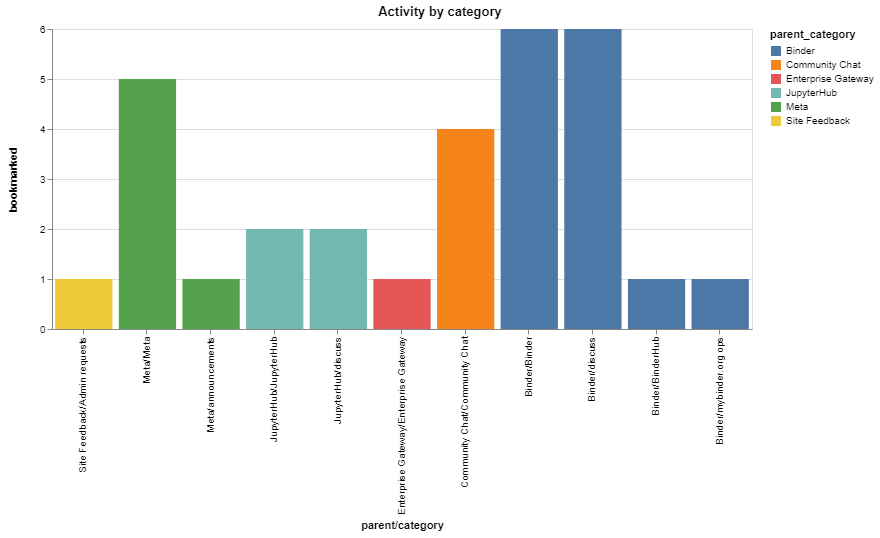

In [10]:
counts = counts_from_activity(posts)
alt.Chart(data=counts, width=700, height=300, title="Activity by category").mark_bar().encode(
    x=alt.X("parent/category", sort=alt.Sort(counts['category_id'].values.tolist())),
    y="bookmarked",
    color="parent_category"
)

## Recently-created topics

These are topics that were recently created, sorted by the amount of activity
in each one.

In [11]:
params = {"order": "created", "ascending": "False"}
resp = requests.get(url, headers=api, params=params)

# Sort created by the most posted for recently-created posts
created = pd.DataFrame(resp.json()['topic_list']['topics'])
created = created.sort_values('posts_count', ascending=False)
Markdown(topics_to_markdown(created))

* [Bitcoin mining (abuse/security)](https://discourse.jupyter.org/t/bitcoin-mining-abuse-security) (16 posts)
* [I get `Read timed out` errors on when pushing image OVH](https://discourse.jupyter.org/t/i-get-read-timed-out-errors-on-when-pushing-image-ovh) (7 posts)
* [Extension that is notified on notebook open event](https://discourse.jupyter.org/t/extension-that-is-notified-on-notebook-open-event) (6 posts)
* [JupyterLab Rich Context Extensions](https://discourse.jupyter.org/t/jupyterlab-rich-context-extensions) (5 posts)
* [0.5 G for memory limit?](https://discourse.jupyter.org/t/0-5-g-for-memory-limit) (3 posts)
* [Quick question on jupyterlab doc regarding &lt;lab-location&gt;](https://discourse.jupyter.org/t/quick-question-on-jupyterlab-doc-regarding-lab-location) (3 posts)
* [Document domain registration for JupyterHub](https://discourse.jupyter.org/t/document-domain-registration-for-jupyterhub) (3 posts)
* [Too many redirects - Keycloak Authentication](https://discourse.jupyter.org/t/too-many-redirects-keycloak-authentication) (3 posts)
* [Welcoming our new JupyterHub team member: Sarah!](https://discourse.jupyter.org/t/welcoming-our-new-jupyterhub-team-member-sarah) (3 posts)
* [JupyterHub, Binder workshop](https://discourse.jupyter.org/t/jupyterhub-binder-workshop) (3 posts)

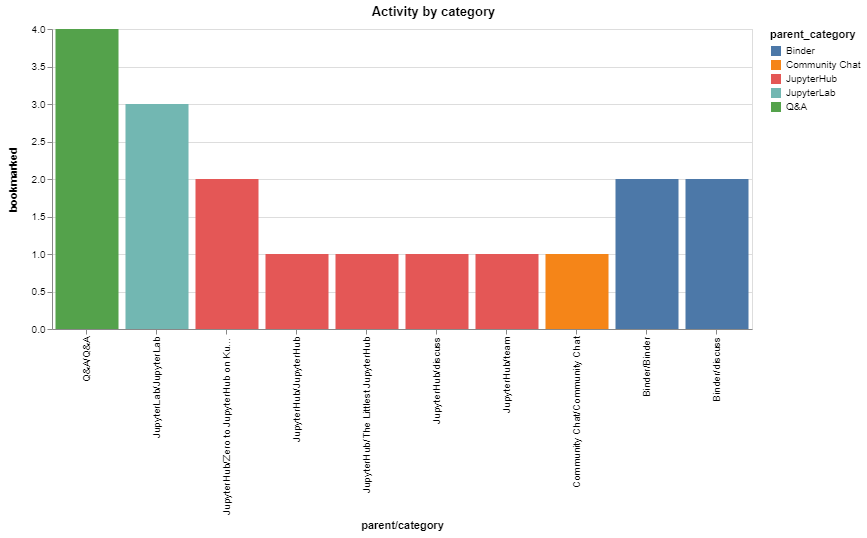

In [12]:
counts = counts_from_activity(created)
alt.Chart(data=counts, width=700, height=300, title="Activity by category").mark_bar().encode(
    x=alt.X("parent/category", sort=alt.Sort(counts['category_id'].values.tolist())),
    y="bookmarked",
    color="parent_category"
)

# GitHub activity

Jupyter also has lots of activity across GitHub repositories. The following sections contain
overviews of recent activity across the following GitHub organizations:

* [github.com/jupyterhub](https://github.com/jupyterhub)
* [github.com/jupyter](https://github.com/jupyter)
* [github.com/jupyterlab](https://github.com/jupyterlab)
* [github.com/jupyter-widgets](https://github.com/jupyter-widgets)

In [60]:
from datetime import timedelta


orgs = ["jupyterhub", "jupyter", "jupyterlab", "jupyter-widgets"]
Markdown(f"Showing GitHub activity from **{start_date}** to **{end_date}**")

Showing GitHub activity from **2019-05-01** to **2019-06-01**

## Merged Pull requests

Here's an analysis of **merged pull requests** across each of the repositories in the Jupyter
ecosystem.

In [61]:
# Update data
merged = []
for org in tqdm(orgs):
    query = f"is:merged user:{org} archived:false closed:{start_date}..{end_date}"
    this_merged = run_github_query(query)
    this_merged['org'] = org
    merged.append(this_merged)
merged = pd.concat(merged)
merged['repo'] = merged['repository_url'].map(lambda a: a.split('/')[-1])

# Count PRs by org/repo
prs_by_repo = merged.groupby(['org', 'repo']).count()['body'].reset_index().sort_values(['org', 'body'], ascending=False)



  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:33<01:41, 33.96s/it]

 50%|█████     | 2/4 [01:23<01:17, 38.58s/it]

 75%|███████▌  | 3/4 [01:50<00:35, 35.10s/it]

100%|██████████| 4/4 [02:01<00:00, 27.96s/it]

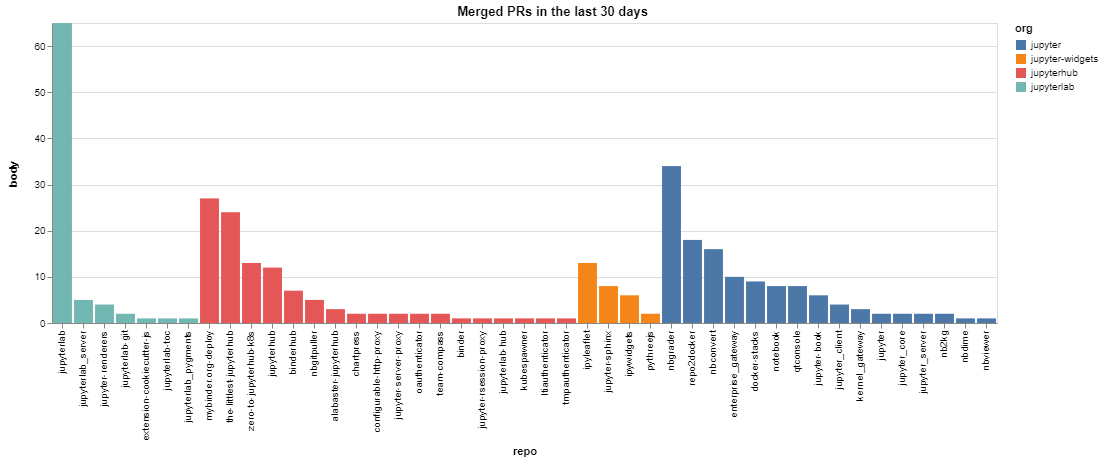

In [62]:
alt.Chart(data=prs_by_repo, title="Merged PRs in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=prs_by_repo['repo'].values.tolist()),
    y='body',
    color='org'
)

### A list of merged PRs by project

In [63]:
markdown = []
for org, idata in merged.groupby('org'):
    markdown.append(f"#### {org}")
    markdown.append("")
    for repourl, prs in idata.groupby('repository_url'):
        reponame, repo = repourl.split('/')[-2:]
        markdown.append(f"##### [{reponame}/{repo}](https://github.com/{reponame}/{repo})")
        for _, pr in prs.iterrows():
            user_name = pr['user']['login']
            user_url = pr['user']['html_url']
            pr_number = pr['number']
            pr_html = pr['html_url']
            pr_title = pr['title']

            text = f"* [(#{pr_number})]({pr_html}): _{pr_title}_ by **[{user_name}]({user_url})**"
            markdown.append(text)
        markdown.append('')
    markdown.append('')

Markdown('\n'.join(markdown))

#### jupyter

##### [jupyter/docker-stacks](https://github.com/jupyter/docker-stacks)
* [(#873)](https://github.com/jupyter/docker-stacks/pull/873): _Apply additional tags to base-notebook_ by **[parente](https://github.com/parente)**
* [(#872)](https://github.com/jupyter/docker-stacks/pull/872): _Update RTD config file to v2_ by **[willingc](https://github.com/willingc)**
* [(#871)](https://github.com/jupyter/docker-stacks/pull/871): _Update to Spark 2.4.3_ by **[parente](https://github.com/parente)**
* [(#870)](https://github.com/jupyter/docker-stacks/pull/870): _Community Stacks documentation ihaskell-notebook_ by **[jamesdbrock](https://github.com/jamesdbrock)**
* [(#869)](https://github.com/jupyter/docker-stacks/pull/869): _jupyterhub 1.0_ by **[minrk](https://github.com/minrk)**
* [(#867)](https://github.com/jupyter/docker-stacks/pull/867): _Changed `conda clean` flags to `--all -f -y`_ by **[echowhisky](https://github.com/echowhisky)**
* [(#864)](https://github.com/jupyter/docker-stacks/pull/864): _Draft pages about translation_ by **[parente](https://github.com/parente)**
* [(#863)](https://github.com/jupyter/docker-stacks/pull/863): _Setup travis en template update_ by **[parente](https://github.com/parente)**
* [(#859)](https://github.com/jupyter/docker-stacks/pull/859): _[Doc] Change Spark Python Notebook entry point sentence_ by **[marcraminv](https://github.com/marcraminv)**
* [(#857)](https://github.com/jupyter/docker-stacks/pull/857): _Build docs, images when appropriate_ by **[parente](https://github.com/parente)**

##### [jupyter/enterprise_gateway](https://github.com/jupyter/enterprise_gateway)
* [(#674)](https://github.com/jupyter/enterprise_gateway/pull/674): _Update platforms.html_ by **[philip-p-jones](https://github.com/philip-p-jones)**
* [(#673)](https://github.com/jupyter/enterprise_gateway/pull/673): _Fix container termination signal handling in EG container_ by **[kevin-bates](https://github.com/kevin-bates)**
* [(#668)](https://github.com/jupyter/enterprise_gateway/pull/668): _Add missing "RUN" command in docs/source/docker.md_ by **[michzimny](https://github.com/michzimny)**
* [(#666)](https://github.com/jupyter/enterprise_gateway/pull/666): _Makefiles: change publish targets to push, use --no-cache on new publish-image target_ by **[kevin-bates](https://github.com/kevin-bates)**
* [(#662)](https://github.com/jupyter/enterprise_gateway/pull/662): _Update helm chart with best practices_ by **[akchinSTC](https://github.com/akchinSTC)**
* [(#658)](https://github.com/jupyter/enterprise_gateway/pull/658): _Update Apache Spark download URL with official archive instead of mirror_ by **[akchinSTC](https://github.com/akchinSTC)**
* [(#651)](https://github.com/jupyter/enterprise_gateway/pull/651): _Add ingress resource to helm chart_ by **[akchinSTC](https://github.com/akchinSTC)**
* [(#645)](https://github.com/jupyter/enterprise_gateway/pull/645): _Refactor KernelSessionManager to accommodate various persistence methods_ by **[kevin-bates](https://github.com/kevin-bates)**
* [(#641)](https://github.com/jupyter/enterprise_gateway/pull/641): _Add daemon to pull kernel images to each node_ by **[kevin-bates](https://github.com/kevin-bates)**
* [(#639)](https://github.com/jupyter/enterprise_gateway/pull/639): _Change kernel-tf-gpu-py image_ by **[esevan](https://github.com/esevan)**

##### [jupyter/jupyter](https://github.com/jupyter/jupyter)
* [(#427)](https://github.com/jupyter/jupyter/pull/427): _May Community Call notes_ by **[Zsailer](https://github.com/Zsailer)**
* [(#425)](https://github.com/jupyter/jupyter/pull/425): _[MRG] Add Jupyter Community Calls_ by **[Zsailer](https://github.com/Zsailer)**

##### [jupyter/jupyter-book](https://github.com/jupyter/jupyter-book)
* [(#197)](https://github.com/jupyter/jupyter-book/pull/197): _Ask if kernelspec exists in metadata_ by **[joergbrech](https://github.com/joergbrech)**
* [(#194)](https://github.com/jupyter/jupyter-book/pull/194): _changelog and version bump_ by **[choldgraf](https://github.com/choldgraf)**
* [(#193)](https://github.com/jupyter/jupyter-book/pull/193): _Release_ by **[choldgraf](https://github.com/choldgraf)**
* [(#190)](https://github.com/jupyter/jupyter-book/pull/190): _Update local install instructions_ by **[mwcraig](https://github.com/mwcraig)**
* [(#188)](https://github.com/jupyter/jupyter-book/pull/188): _fixing some css bugs_ by **[choldgraf](https://github.com/choldgraf)**
* [(#187)](https://github.com/jupyter/jupyter-book/pull/187): _[FIX] Issue #137 Errors when running on Windows_ by **[stafforddavidj](https://github.com/stafforddavidj)**

##### [jupyter/jupyter_client](https://github.com/jupyter/jupyter_client)
* [(#440)](https://github.com/jupyter/jupyter_client/pull/440): _Add xeus to the documentation on how to write a kernel for Jupyter_ by **[martinRenou](https://github.com/martinRenou)**
* [(#438)](https://github.com/jupyter/jupyter_client/pull/438): _Backport PR #437: Avoid kernel failures with multiple processes_ by **[alexrudy](https://github.com/alexrudy)**
* [(#437)](https://github.com/jupyter/jupyter_client/pull/437): _Avoid kernel failures with multiple processes_ by **[alexrudy](https://github.com/alexrudy)**
* [(#432)](https://github.com/jupyter/jupyter_client/pull/432): _Configure the connection_file if not already done_ by **[SpencerPark](https://github.com/SpencerPark)**

##### [jupyter/jupyter_core](https://github.com/jupyter/jupyter_core)
* [(#150)](https://github.com/jupyter/jupyter_core/pull/150): _Drop Python 3.3 from Travis CI_ by **[takluyver](https://github.com/takluyver)**
* [(#147)](https://github.com/jupyter/jupyter_core/pull/147): _Always use setuptools in setup.py_ by **[coldfix](https://github.com/coldfix)**

##### [jupyter/jupyter_server](https://github.com/jupyter/jupyter_server)
* [(#49)](https://github.com/jupyter/jupyter_server/pull/49): _Add localhost to list of default local_hostnames_ by **[aschlaep](https://github.com/aschlaep)**
* [(#47)](https://github.com/jupyter/jupyter_server/pull/47): _Remove bundler endpoints_ by **[SylvainCorlay](https://github.com/SylvainCorlay)**

##### [jupyter/kernel_gateway](https://github.com/jupyter/kernel_gateway)
* [(#319)](https://github.com/jupyter/kernel_gateway/pull/319): _Update build status badge in README_ by **[willingc](https://github.com/willingc)**
* [(#318)](https://github.com/jupyter/kernel_gateway/pull/318): _Enable Python 3.7 on travis_ by **[dleen](https://github.com/dleen)**
* [(#317)](https://github.com/jupyter/kernel_gateway/pull/317): _Fix bug when other jupyter server running_ by **[dleen](https://github.com/dleen)**

##### [jupyter/nb2kg](https://github.com/jupyter/nb2kg)
* [(#35)](https://github.com/jupyter/nb2kg/pull/35): _Increase http timeout default values_ by **[kevin-bates](https://github.com/kevin-bates)**
* [(#33)](https://github.com/jupyter/nb2kg/pull/33): _Update handlers.py_ by **[SolarisYan](https://github.com/SolarisYan)**

##### [jupyter/nbconvert](https://github.com/jupyter/nbconvert)
* [(#1039)](https://github.com/jupyter/nbconvert/pull/1039): _Fix LaTeX exporting '?' for non-ascii title_ by **[imtsuki](https://github.com/imtsuki)**
* [(#1030)](https://github.com/jupyter/nbconvert/pull/1030): _Fix Testing on Windows_ by **[t-makaro](https://github.com/t-makaro)**
* [(#1029)](https://github.com/jupyter/nbconvert/pull/1029): _Correct a few typos_ by **[t-makaro](https://github.com/t-makaro)**
* [(#1027)](https://github.com/jupyter/nbconvert/pull/1027): _update export_from_notebook names_ by **[t-makaro](https://github.com/t-makaro)**
* [(#1024)](https://github.com/jupyter/nbconvert/pull/1024): _Latex improvements_ by **[t-makaro](https://github.com/t-makaro)**
* [(#1023)](https://github.com/jupyter/nbconvert/pull/1023): _dedenting html in ExtractOutputPreprocessor_ by **[amniskin](https://github.com/amniskin)**
* [(#1022)](https://github.com/jupyter/nbconvert/pull/1022): _Fix backwards incompatibility with markdown2html_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1021)](https://github.com/jupyter/nbconvert/pull/1021): _kwargs is used when km is exist, but not defind in func._ by **[00Kai0](https://github.com/00Kai0)**
* [(#1019)](https://github.com/jupyter/nbconvert/pull/1019): _Fix doc build_ by **[willingc](https://github.com/willingc)**
* [(#1017)](https://github.com/jupyter/nbconvert/pull/1017): _Disable IPython History in executing preprocessor_ by **[alexrudy](https://github.com/alexrudy)**
* [(#1015)](https://github.com/jupyter/nbconvert/pull/1015): _Removed newlines from clear notebook test. Refactored test_run_notebooks_ by **[MSeal](https://github.com/MSeal)**
* [(#1013)](https://github.com/jupyter/nbconvert/pull/1013): _Close image tag_ by **[SylvainCorlay](https://github.com/SylvainCorlay)**
* [(#1011)](https://github.com/jupyter/nbconvert/pull/1011): _Require mock for tests_ by **[hroncok](https://github.com/hroncok)**
* [(#1010)](https://github.com/jupyter/nbconvert/pull/1010): _Remove un-necessary css_ by **[SylvainCorlay](https://github.com/SylvainCorlay)**
* [(#1009)](https://github.com/jupyter/nbconvert/pull/1009): _Couldn't pass by_ by **[manycoding](https://github.com/manycoding)**
* [(#994)](https://github.com/jupyter/nbconvert/pull/994): _Fixing #659 (output cutoff and iopub timeout)_ by **[djherbis](https://github.com/djherbis)**

##### [jupyter/nbdime](https://github.com/jupyter/nbdime)
* [(#475)](https://github.com/jupyter/nbdime/pull/475): _Fix styling issue_ by **[vidartf](https://github.com/vidartf)**

##### [jupyter/nbgrader](https://github.com/jupyter/nbgrader)
* [(#1127)](https://github.com/jupyter/nbgrader/pull/1127): _Better documentation of nbgrader_config.py_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1126)](https://github.com/jupyter/nbgrader/pull/1126): _Remove the third party resources page_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1125)](https://github.com/jupyter/nbgrader/pull/1125): _Check that the course directory is a subdirectory of the notebook dir_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1124)](https://github.com/jupyter/nbgrader/pull/1124): _Only run nbextensions tests on oldest and newest versions of python_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1122)](https://github.com/jupyter/nbgrader/pull/1122): _Fix incorrect usage of Exchange.course_id_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1121)](https://github.com/jupyter/nbgrader/pull/1121): _Fix logfile_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1119)](https://github.com/jupyter/nbgrader/pull/1119): _added a sanatizing step to the doc creation. _ by **[danielmaitre](https://github.com/danielmaitre)**
* [(#1118)](https://github.com/jupyter/nbgrader/pull/1118): _Integrate course_id into the api and apps_ by **[damianavila](https://github.com/damianavila)**
* [(#1116)](https://github.com/jupyter/nbgrader/pull/1116): _Autograde & Assign: create missing students/assignments by default_ by **[takluyver](https://github.com/takluyver)**
* [(#1115)](https://github.com/jupyter/nbgrader/pull/1115): _Fix typo in tmp filename prefix in conftest.py_ by **[slel](https://github.com/slel)**
* [(#1113)](https://github.com/jupyter/nbgrader/pull/1113): _Add a course list extension that shows all courses an instructor can manage_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1112)](https://github.com/jupyter/nbgrader/pull/1112): _Locate all configurable classes for generate_config subcommand_ by **[takluyver](https://github.com/takluyver)**
* [(#1110)](https://github.com/jupyter/nbgrader/pull/1110): _Systematic use of utils.get_username instead of $USER_ by **[nthiery](https://github.com/nthiery)**
* [(#1109)](https://github.com/jupyter/nbgrader/pull/1109): _naming the temporary directories in tests_ by **[danielmaitre](https://github.com/danielmaitre)**
* [(#1108)](https://github.com/jupyter/nbgrader/pull/1108): _Extended support for filtering files copied in the exchange_ by **[nthiery](https://github.com/nthiery)**
* [(#1106)](https://github.com/jupyter/nbgrader/pull/1106): _Remove testing of python 3.4_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1105)](https://github.com/jupyter/nbgrader/pull/1105): _Remove extra keys in nbgrader metadata and better schema mismatch errors_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1102)](https://github.com/jupyter/nbgrader/pull/1102): _Only build docs with one version of python_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1101)](https://github.com/jupyter/nbgrader/pull/1101): _Add jupyter education book to third party resources_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1100)](https://github.com/jupyter/nbgrader/pull/1100): _Run test in the `python` group in parallel using pytest-xdist_ by **[BertR](https://github.com/BertR)**
* [(#1098)](https://github.com/jupyter/nbgrader/pull/1098): _Customizable student ID in `nbgrader submit`_ by **[nthiery](https://github.com/nthiery)**
* [(#1094)](https://github.com/jupyter/nbgrader/pull/1094): _Update license_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1093)](https://github.com/jupyter/nbgrader/pull/1093): _Add authentication plugin support_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1088)](https://github.com/jupyter/nbgrader/pull/1088): _Remove version requirement from urllib3_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1084)](https://github.com/jupyter/nbgrader/pull/1084): _Fix miscellaneous bugs_ by **[jhamrick](https://github.com/jhamrick)**
* [(#1080)](https://github.com/jupyter/nbgrader/pull/1080): _compatibility with SQLAlchemy 1.3+_ by **[gertingold](https://github.com/gertingold)**
* [(#1075)](https://github.com/jupyter/nbgrader/pull/1075): _Give ExecutePreprocessor the Traitlets config during validation_ by **[rkdarst](https://github.com/rkdarst)**
* [(#1071)](https://github.com/jupyter/nbgrader/pull/1071): _student and assignment selection in exportapp implemented_ by **[ddland](https://github.com/ddland)**
* [(#1064)](https://github.com/jupyter/nbgrader/pull/1064): _Validate all cells_ by **[rkdarst](https://github.com/rkdarst)**
* [(#1061)](https://github.com/jupyter/nbgrader/pull/1061): _Set env var NBGRADER_VALIDATING when validating_ by **[rkdarst](https://github.com/rkdarst)**
* [(#1040)](https://github.com/jupyter/nbgrader/pull/1040): _Restrict access for students to different courses_ by **[sigurdurb](https://github.com/sigurdurb)**
* [(#1036)](https://github.com/jupyter/nbgrader/pull/1036): _Add a general lms user id column to the student table_ by **[sigurdurb](https://github.com/sigurdurb)**
* [(#1001)](https://github.com/jupyter/nbgrader/pull/1001): _Allow setting a different assignment dir for students than the root notebook directory_ by **[rkdarst](https://github.com/rkdarst)**
* [(#967)](https://github.com/jupyter/nbgrader/pull/967): _Added note in FAQ about changing cell ids_ by **[Ciemaar](https://github.com/Ciemaar)**

##### [jupyter/nbviewer](https://github.com/jupyter/nbviewer)
* [(#829)](https://github.com/jupyter/nbviewer/pull/829): _Additional logging for file permission issues_ by **[krishnatg](https://github.com/krishnatg)**

##### [jupyter/notebook](https://github.com/jupyter/notebook)
* [(#4642)](https://github.com/jupyter/notebook/pull/4642): _Use JavaScript to redirect users_ by **[betatim](https://github.com/betatim)**
* [(#4623)](https://github.com/jupyter/notebook/pull/4623): _Make tooltip buttons have consistent appearance_ by **[mtd91429](https://github.com/mtd91429)**
* [(#4617)](https://github.com/jupyter/notebook/pull/4617): _Migrate multiselect toggle test to selenium_ by **[TeresaPartidaS](https://github.com/TeresaPartidaS)**
* [(#4615)](https://github.com/jupyter/notebook/pull/4615): _Convert dualmode_execute, dualmode_clipboard & dualmode_markdown to selenium_ by **[LuisARodr](https://github.com/LuisARodr)**
* [(#4608)](https://github.com/jupyter/notebook/pull/4608): _Convert dualmode_cellmode to selenium_ by **[LuisARodr](https://github.com/LuisARodr)**
* [(#4591)](https://github.com/jupyter/notebook/pull/4591): _Update Working With Markdown Cells.ipynb_ by **[dalanicolai](https://github.com/dalanicolai)**
* [(#4588)](https://github.com/jupyter/notebook/pull/4588): _fix duplicates in download as menu_ by **[t-makaro](https://github.com/t-makaro)**
* [(#4563)](https://github.com/jupyter/notebook/pull/4563): _Converted clipboard js to selenium and renamed undelete.py_ by **[emiliotl](https://github.com/emiliotl)**

##### [jupyter/qtconsole](https://github.com/jupyter/qtconsole)
* [(#344)](https://github.com/jupyter/qtconsole/pull/344): _Several improvements to the Readme_ by **[ccordoba12](https://github.com/ccordoba12)**
* [(#343)](https://github.com/jupyter/qtconsole/pull/343): _Move setup.py to use setuptools instead of distutils_ by **[ccordoba12](https://github.com/ccordoba12)**
* [(#342)](https://github.com/jupyter/qtconsole/pull/342): _Update Changelog with 4.5 changes_ by **[ccordoba12](https://github.com/ccordoba12)**
* [(#341)](https://github.com/jupyter/qtconsole/pull/341): _PR: Use new traitlets API with decorators_ by **[dalthviz](https://github.com/dalthviz)**
* [(#340)](https://github.com/jupyter/qtconsole/pull/340): _Remove metadata entry from setup.cfg_ by **[ccordoba12](https://github.com/ccordoba12)**
* [(#339)](https://github.com/jupyter/qtconsole/pull/339): _Use Readme.md for long_description in setup.py_ by **[ccordoba12](https://github.com/ccordoba12)**
* [(#338)](https://github.com/jupyter/qtconsole/pull/338): _PR: Add Comms to qtconsole_ by **[impact27](https://github.com/impact27)**
* [(#336)](https://github.com/jupyter/qtconsole/pull/336): _PR: Add language name as attribute of the JupyterWidget_ by **[dalthviz](https://github.com/dalthviz)**

##### [jupyter/repo2docker](https://github.com/jupyter/repo2docker)
* [(#697)](https://github.com/jupyter/repo2docker/pull/697): _Upgrade JupyterHub to 1.0_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#695)](https://github.com/jupyter/repo2docker/pull/695): _[MRG] Update verification of Node install_ by **[betatim](https://github.com/betatim)**
* [(#693)](https://github.com/jupyter/repo2docker/pull/693): _[MRG] Zenodo content provider_ by **[betatim](https://github.com/betatim)**
* [(#692)](https://github.com/jupyter/repo2docker/pull/692): _Adding contentprovider documentation_ by **[choldgraf](https://github.com/choldgraf)**
* [(#690)](https://github.com/jupyter/repo2docker/pull/690): _set CONDA_DEFAULT_ENV_ by **[minrk](https://github.com/minrk)**
* [(#689)](https://github.com/jupyter/repo2docker/pull/689): _Switch Travis CI to Ubuntu Xenial 16.04_ by **[jrbourbeau](https://github.com/jrbourbeau)**
* [(#684)](https://github.com/jupyter/repo2docker/pull/684): _[MRG] Drop support for Python 3.4_ by **[betatim](https://github.com/betatim)**
* [(#683)](https://github.com/jupyter/repo2docker/pull/683): _[MRG] Use getpass instead of pwd to fetch username_ by **[betatim](https://github.com/betatim)**
* [(#679)](https://github.com/jupyter/repo2docker/pull/679): _Do not try to build the image with root as the primary user_ by **[Xarthisius](https://github.com/Xarthisius)**
* [(#678)](https://github.com/jupyter/repo2docker/pull/678): _Revert "[MRG] Do not try to build the image with root as the primary user."_ by **[betatim](https://github.com/betatim)**
* [(#677)](https://github.com/jupyter/repo2docker/pull/677): _[MRG] Update base image used for memory limit checks_ by **[betatim](https://github.com/betatim)**
* [(#676)](https://github.com/jupyter/repo2docker/pull/676): _[MRG] Do not try to build the image with root as the primary user._ by **[Xarthisius](https://github.com/Xarthisius)**
* [(#669)](https://github.com/jupyter/repo2docker/pull/669): _bumping release date_ by **[choldgraf](https://github.com/choldgraf)**
* [(#668)](https://github.com/jupyter/repo2docker/pull/668): _[MRG] release info updates_ by **[choldgraf](https://github.com/choldgraf)**
* [(#666)](https://github.com/jupyter/repo2docker/pull/666): _[MRG] Remove the conda package cache as we can't hardlink to it_ by **[betatim](https://github.com/betatim)**
* [(#664)](https://github.com/jupyter/repo2docker/pull/664): _[MRG] Update change log in preparation for releasing v0.9.0_ by **[betatim](https://github.com/betatim)**
* [(#663)](https://github.com/jupyter/repo2docker/pull/663): _tweak language to make clear `exec "$@"` works_ by **[fomightez](https://github.com/fomightez)**
* [(#662)](https://github.com/jupyter/repo2docker/pull/662): _specification info page_ by **[choldgraf](https://github.com/choldgraf)**


#### jupyter-widgets

##### [jupyter-widgets/ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet)
* [(#368)](https://github.com/jupyter-widgets/ipyleaflet/pull/368): _geodata class_ by **[VasavanThiru](https://github.com/VasavanThiru)**
* [(#366)](https://github.com/jupyter-widgets/ipyleaflet/pull/366): _Adding an example of selecting GeoJSON features by clicking on the leaflet layer_ by **[mpdwulit](https://github.com/mpdwulit)**
* [(#365)](https://github.com/jupyter-widgets/ipyleaflet/pull/365): _choropleth doc improvement_ by **[VasavanThiru](https://github.com/VasavanThiru)**
* [(#360)](https://github.com/jupyter-widgets/ipyleaflet/pull/360): _Add doc for no_wrap option_ by **[kgiacobbi](https://github.com/kgiacobbi)**
* [(#359)](https://github.com/jupyter-widgets/ipyleaflet/pull/359): _Add no_wrap option for TileLayer_ by **[kgiacobbi](https://github.com/kgiacobbi)**
* [(#355)](https://github.com/jupyter-widgets/ipyleaflet/pull/355): _Add layers control to map every time a layer is added_ by **[fitoprincipe](https://github.com/fitoprincipe)**
* [(#353)](https://github.com/jupyter-widgets/ipyleaflet/pull/353): _Use more robust check before using noConflict() mode_ by **[Kirill888](https://github.com/Kirill888)**
* [(#352)](https://github.com/jupyter-widgets/ipyleaflet/pull/352): _Fix map size issue_ by **[martinRenou](https://github.com/martinRenou)**
* [(#351)](https://github.com/jupyter-widgets/ipyleaflet/pull/351): _Expose fullscreen control/state_ by **[Kirill888](https://github.com/Kirill888)**
* [(#349)](https://github.com/jupyter-widgets/ipyleaflet/pull/349): _Fix styling problems for GeoJSON_ by **[Kirill888](https://github.com/Kirill888)**
* [(#344)](https://github.com/jupyter-widgets/ipyleaflet/pull/344): _Use latest version of leaflet-draw plugin_ by **[Kirill888](https://github.com/Kirill888)**
* [(#343)](https://github.com/jupyter-widgets/ipyleaflet/pull/343): _Change name of OpenTopoMap from 'OpenTopMap' to 'OpenTopoMap'_ by **[Swanson-Hysell](https://github.com/Swanson-Hysell)**
* [(#339)](https://github.com/jupyter-widgets/ipyleaflet/pull/339): _add MapStyle to change Map's css style, aiming to change the cursor type_ by **[fitoprincipe](https://github.com/fitoprincipe)**

##### [jupyter-widgets/ipywidgets](https://github.com/jupyter-widgets/ipywidgets)
* [(#2425)](https://github.com/jupyter-widgets/ipywidgets/pull/2425): _Remove unused scrollIfNeeded and StyleModel import_ by **[jtpio](https://github.com/jtpio)**
* [(#2423)](https://github.com/jupyter-widgets/ipywidgets/pull/2423): _#2422 provide type explicitly to fix complilation_ by **[throwable-one](https://github.com/throwable-one)**
* [(#2421)](https://github.com/jupyter-widgets/ipywidgets/pull/2421): _Update for JLab 1.0a5._ by **[jasongrout](https://github.com/jasongrout)**
* [(#2418)](https://github.com/jupyter-widgets/ipywidgets/pull/2418): _Drop postcss_ by **[SylvainCorlay](https://github.com/SylvainCorlay)**
* [(#2409)](https://github.com/jupyter-widgets/ipywidgets/pull/2409): _Remove the overflow exception for the shorthand property_ by **[SylvainCorlay](https://github.com/SylvainCorlay)**
* [(#2315)](https://github.com/jupyter-widgets/ipywidgets/pull/2315): _Enable noImplicitAny compiler check, fix tslint errors._ by **[blois](https://github.com/blois)**

##### [jupyter-widgets/jupyter-sphinx](https://github.com/jupyter-widgets/jupyter-sphinx)
* [(#49)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/49): _add javascript support_ by **[basnijholt](https://github.com/basnijholt)**
* [(#46)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/46): _configure travis_ by **[akhmerov](https://github.com/akhmerov)**
* [(#44)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/44): _remove embed_widgets extension_ by **[jbweston](https://github.com/jbweston)**
* [(#42)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/42): _add tests and test configuration_ by **[jbweston](https://github.com/jbweston)**
* [(#39)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/39): _Docs_ by **[jbweston](https://github.com/jbweston)**
* [(#38)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/38): _enable parallel execution_ by **[jbweston](https://github.com/jbweston)**
* [(#29)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/29): _strip unecessary newlines when content is loaded from a file_ by **[jbweston](https://github.com/jbweston)**
* [(#24)](https://github.com/jupyter-widgets/jupyter-sphinx/pull/24): _add support for rendering ipywidgets_ by **[jbweston](https://github.com/jbweston)**

##### [jupyter-widgets/pythreejs](https://github.com/jupyter-widgets/pythreejs)
* [(#272)](https://github.com/jupyter-widgets/pythreejs/pull/272): _Update traits.py for collections deprecation warning_ by **[GenevieveBuckley](https://github.com/GenevieveBuckley)**
* [(#271)](https://github.com/jupyter-widgets/pythreejs/pull/271): _Update pythreejs.py to silence traitlets warning_ by **[GenevieveBuckley](https://github.com/GenevieveBuckley)**


#### jupyterhub

##### [jupyterhub/alabaster-jupyterhub](https://github.com/jupyterhub/alabaster-jupyterhub)
* [(#18)](https://github.com/jupyterhub/alabaster-jupyterhub/pull/18): _dev version bump 1.7_ by **[choldgraf](https://github.com/choldgraf)**
* [(#17)](https://github.com/jupyterhub/alabaster-jupyterhub/pull/17): _version bump_ by **[choldgraf](https://github.com/choldgraf)**
* [(#16)](https://github.com/jupyterhub/alabaster-jupyterhub/pull/16): _enabling right sidebar scrolling and spacing tweaks and edit on github_ by **[choldgraf](https://github.com/choldgraf)**

##### [jupyterhub/binder](https://github.com/jupyterhub/binder)
* [(#164)](https://github.com/jupyterhub/binder/pull/164): _faq billing link uses lab now_ by **[choldgraf](https://github.com/choldgraf)**

##### [jupyterhub/binderhub](https://github.com/jupyterhub/binderhub)
* [(#860)](https://github.com/jupyterhub/binderhub/pull/860): _[MRG] rename variable and restructure API docs_ by **[nuest](https://github.com/nuest)**
* [(#858)](https://github.com/jupyterhub/binderhub/pull/858): _[MRG] Tweak loading messages_ by **[betatim](https://github.com/betatim)**
* [(#857)](https://github.com/jupyterhub/binderhub/pull/857): _fix tolerations in dind daemonset and add tolerations to image-cleaner_ by **[jhamman](https://github.com/jhamman)**
* [(#856)](https://github.com/jupyterhub/binderhub/pull/856): _add user tolerations to dind daemonset_ by **[jhamman](https://github.com/jhamman)**
* [(#853)](https://github.com/jupyterhub/binderhub/pull/853): _add default toleration to build pods_ by **[jhamman](https://github.com/jhamman)**
* [(#847)](https://github.com/jupyterhub/binderhub/pull/847): _Discuss indentation of configuration files in debugging docs_ by **[sgibson91](https://github.com/sgibson91)**
* [(#841)](https://github.com/jupyterhub/binderhub/pull/841): _Revert "Update to Docs: Clarify where in secret.yaml GitHub Personal Access Token should be added"_ by **[sgibson91](https://github.com/sgibson91)**

##### [jupyterhub/chartpress](https://github.com/jupyterhub/chartpress)
* [(#34)](https://github.com/jupyterhub/chartpress/pull/34): _avoid mangling of quotes in rendered charts (#1)_ by **[rokroskar](https://github.com/rokroskar)**
* [(#28)](https://github.com/jupyterhub/chartpress/pull/28): _provide a reset option to reset image tags and chart version_ by **[rokroskar](https://github.com/rokroskar)**

##### [jupyterhub/configurable-http-proxy](https://github.com/jupyterhub/configurable-http-proxy)
* [(#202)](https://github.com/jupyterhub/configurable-http-proxy/pull/202): _chore(deps): update dependency nyc to v14_ by **[renovate[bot]](https://github.com/apps/renovate)**
* [(#201)](https://github.com/jupyterhub/configurable-http-proxy/pull/201): _Update dependency commander to ~2.20.0_ by **[renovate[bot]](https://github.com/apps/renovate)**

##### [jupyterhub/jupyter-rsession-proxy](https://github.com/jupyterhub/jupyter-rsession-proxy)
* [(#67)](https://github.com/jupyterhub/jupyter-rsession-proxy/pull/67): _Include LICENSE.txt in sdist and wheel_ by **[xhochy](https://github.com/xhochy)**

##### [jupyterhub/jupyter-server-proxy](https://github.com/jupyterhub/jupyter-server-proxy)
* [(#132)](https://github.com/jupyterhub/jupyter-server-proxy/pull/132): _install-doc-update_ by **[quasiben](https://github.com/quasiben)**
* [(#128)](https://github.com/jupyterhub/jupyter-server-proxy/pull/128): _Allow for other hosts than `localhost` to be proxied._ by **[ian-r-rose](https://github.com/ian-r-rose)**

##### [jupyterhub/jupyterhub](https://github.com/jupyterhub/jupyterhub)
* [(#2584)](https://github.com/jupyterhub/jupyterhub/pull/2584): _re-raise exceptions in launch_instance_async_ by **[minrk](https://github.com/minrk)**
* [(#2565)](https://github.com/jupyterhub/jupyterhub/pull/2565): _Update link of `changelog`_ by **[iblis17](https://github.com/iblis17)**
* [(#2564)](https://github.com/jupyterhub/jupyterhub/pull/2564): _typo_ by **[julienchastang](https://github.com/julienchastang)**
* [(#2558)](https://github.com/jupyterhub/jupyterhub/pull/2558): _Update to simplify the language related to spawner options_ by **[NikeNano](https://github.com/NikeNano)**
* [(#2548)](https://github.com/jupyterhub/jupyterhub/pull/2548): _Adding the use case of the Elucidata: How Jupyter Notebook is used in…_ by **[IamViditAgarwal](https://github.com/IamViditAgarwal)**
* [(#2546)](https://github.com/jupyterhub/jupyterhub/pull/2546): _Dict rewritten as literal_ by **[remyleone](https://github.com/remyleone)**
* [(#2545)](https://github.com/jupyterhub/jupyterhub/pull/2545): _releasing 1.0_ by **[minrk](https://github.com/minrk)**
* [(#2544)](https://github.com/jupyterhub/jupyterhub/pull/2544): _[autodoc] move config sample to annotation_ by **[minrk](https://github.com/minrk)**
* [(#2543)](https://github.com/jupyterhub/jupyterhub/pull/2543): _pin mysql-connector-python on travis_ by **[minrk](https://github.com/minrk)**
* [(#2538)](https://github.com/jupyterhub/jupyterhub/pull/2538): _Update gallery-jhub-deployments.md_ by **[labarba](https://github.com/labarba)**
* [(#2534)](https://github.com/jupyterhub/jupyterhub/pull/2534): _Refactor Logout Handler_ by **[distortedsignal](https://github.com/distortedsignal)**
* [(#2524)](https://github.com/jupyterhub/jupyterhub/pull/2524): _test postgres with url-encoded password_ by **[minrk](https://github.com/minrk)**

##### [jupyterhub/jupyterlab-hub](https://github.com/jupyterhub/jupyterlab-hub)
* [(#86)](https://github.com/jupyterhub/jupyterlab-hub/pull/86): _Updates for JL 1.0.0-alpha.6_ by **[athornton](https://github.com/athornton)**

##### [jupyterhub/kubespawner](https://github.com/jupyterhub/kubespawner)
* [(#321)](https://github.com/jupyterhub/kubespawner/pull/321): _Add {username} expansion to extra_pod_config_ by **[cgiraldo](https://github.com/cgiraldo)**

##### [jupyterhub/ltiauthenticator](https://github.com/jupyterhub/ltiauthenticator)
* [(#15)](https://github.com/jupyterhub/ltiauthenticator/pull/15): _Link to Canvas' external app docs._ by **[ryanlovett](https://github.com/ryanlovett)**

##### [jupyterhub/mybinder.org-deploy](https://github.com/jupyterhub/mybinder.org-deploy)
* [(#993)](https://github.com/jupyterhub/mybinder.org-deploy/pull/993): _binderhub: 9f83710...851025f_ by **[henchbot](https://github.com/henchbot)**
* [(#992)](https://github.com/jupyterhub/mybinder.org-deploy/pull/992): _Use "weird" timeouts_ by **[betatim](https://github.com/betatim)**
* [(#991)](https://github.com/jupyterhub/mybinder.org-deploy/pull/991): _repo2docker: 51898274...80fbc639_ by **[henchbot](https://github.com/henchbot)**
* [(#990)](https://github.com/jupyterhub/mybinder.org-deploy/pull/990): _repo2docker: 80b979f8...51898274_ by **[henchbot](https://github.com/henchbot)**
* [(#988)](https://github.com/jupyterhub/mybinder.org-deploy/pull/988): _Add README for federation redirector_ by **[betatim](https://github.com/betatim)**
* [(#987)](https://github.com/jupyterhub/mybinder.org-deploy/pull/987): _Add a redirector for the mybinder.org federation_ by **[betatim](https://github.com/betatim)**
* [(#984)](https://github.com/jupyterhub/mybinder.org-deploy/pull/984): _Add hmharshit/mltraining which is a fork of a previously banned repo_ by **[betatim](https://github.com/betatim)**
* [(#983)](https://github.com/jupyterhub/mybinder.org-deploy/pull/983): _Bump repo2docker and binderhub_ by **[betatim](https://github.com/betatim)**
* [(#982)](https://github.com/jupyterhub/mybinder.org-deploy/pull/982): _Revert "repo2docker: 91309cab...80b979f8"_ by **[choldgraf](https://github.com/choldgraf)**
* [(#981)](https://github.com/jupyterhub/mybinder.org-deploy/pull/981): _Revert "binderhub: 82fc209...9f83710"_ by **[henchc](https://github.com/henchc)**
* [(#979)](https://github.com/jupyterhub/mybinder.org-deploy/pull/979): _binderhub: 82fc209...9f83710_ by **[henchbot](https://github.com/henchbot)**
* [(#978)](https://github.com/jupyterhub/mybinder.org-deploy/pull/978): _repo2docker: 91309cab...80b979f8_ by **[henchbot](https://github.com/henchbot)**
* [(#976)](https://github.com/jupyterhub/mybinder.org-deploy/pull/976): _binderhub: 10ac4d8...82fc209_ by **[henchbot](https://github.com/henchbot)**
* [(#975)](https://github.com/jupyterhub/mybinder.org-deploy/pull/975): _Fix typo in repo ban_ by **[betatim](https://github.com/betatim)**
* [(#974)](https://github.com/jupyterhub/mybinder.org-deploy/pull/974): _Ban shishirchoudharygic/mltraining_ by **[betatim](https://github.com/betatim)**
* [(#973)](https://github.com/jupyterhub/mybinder.org-deploy/pull/973): _Open an additional port for the xroot protocol_ by **[betatim](https://github.com/betatim)**
* [(#972)](https://github.com/jupyterhub/mybinder.org-deploy/pull/972): _repo2docker: 25ebca04...91309cab_ by **[henchbot](https://github.com/henchbot)**
* [(#971)](https://github.com/jupyterhub/mybinder.org-deploy/pull/971): _Ban hmharshit/cn-ait for the moment_ by **[betatim](https://github.com/betatim)**
* [(#970)](https://github.com/jupyterhub/mybinder.org-deploy/pull/970): _Adding new configuration for OVH cluster_ by **[mael-le-gal](https://github.com/mael-le-gal)**
* [(#967)](https://github.com/jupyterhub/mybinder.org-deploy/pull/967): _analytics-publisher: Cleanup cloud costs schema_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#966)](https://github.com/jupyterhub/mybinder.org-deploy/pull/966): _repo2docker: d674ecee...25ebca04_ by **[henchbot](https://github.com/henchbot)**
* [(#965)](https://github.com/jupyterhub/mybinder.org-deploy/pull/965): _Revert "repo2docker: d674ecee...4514ba31"_ by **[sgibson91](https://github.com/sgibson91)**
* [(#964)](https://github.com/jupyterhub/mybinder.org-deploy/pull/964): _repo2docker: d674ecee...4514ba31_ by **[sgibson91](https://github.com/sgibson91)**
* [(#963)](https://github.com/jupyterhub/mybinder.org-deploy/pull/963): _analytics-publisher: Bump jinja2 version_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#962)](https://github.com/jupyterhub/mybinder.org-deploy/pull/962): _repo2docker: df89849e...d674ecee_ by **[henchc](https://github.com/henchc)**
* [(#961)](https://github.com/jupyterhub/mybinder.org-deploy/pull/961): _repo2docker: 9099def4...df89849e_ by **[henchc](https://github.com/henchc)**
* [(#849)](https://github.com/jupyterhub/mybinder.org-deploy/pull/849): _Automatically publish cloud compute costs_ by **[yuvipanda](https://github.com/yuvipanda)**

##### [jupyterhub/nbgitpuller](https://github.com/jupyterhub/nbgitpuller)
* [(#88)](https://github.com/jupyterhub/nbgitpuller/pull/88): _documentation clarification_ by **[parmentelat](https://github.com/parmentelat)**
* [(#82)](https://github.com/jupyterhub/nbgitpuller/pull/82): _circle config to push docs_ by **[choldgraf](https://github.com/choldgraf)**
* [(#81)](https://github.com/jupyterhub/nbgitpuller/pull/81): _adding documentation_ by **[choldgraf](https://github.com/choldgraf)**
* [(#79)](https://github.com/jupyterhub/nbgitpuller/pull/79): _Don't require including cloned dir name in path to open_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#78)](https://github.com/jupyterhub/nbgitpuller/pull/78): _Generate URLs that can be launched from canvas_ by **[yuvipanda](https://github.com/yuvipanda)**

##### [jupyterhub/oauthenticator](https://github.com/jupyterhub/oauthenticator)
* [(#261)](https://github.com/jupyterhub/oauthenticator/pull/261): _Allow option to disable basic auth header in generic oauth_ by **[sunnielyu](https://github.com/sunnielyu)**
* [(#257)](https://github.com/jupyterhub/oauthenticator/pull/257): _OpenShift 4.0 splits OAuth provider out of REST API URL host._ by **[GrahamDumpleton](https://github.com/GrahamDumpleton)**

##### [jupyterhub/team-compass](https://github.com/jupyterhub/team-compass)
* [(#161)](https://github.com/jupyterhub/team-compass/pull/161): _Change May notes to 2019_ by **[Zsailer](https://github.com/Zsailer)**
* [(#158)](https://github.com/jupyterhub/team-compass/pull/158): _Add the May team meeting notes_ by **[lheagy](https://github.com/lheagy)**

##### [jupyterhub/the-littlest-jupyterhub](https://github.com/jupyterhub/the-littlest-jupyterhub)
* [(#359)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/359): _Install & use pycurl for requests_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#358)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/358): _Minor azure doc cleanup_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#357)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/357): _Suppress insecure HTTPS warning when upgrading TLJH_ by **[GeorgianaElena](https://github.com/GeorgianaElena)**
* [(#355)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/355): _Fixed out of date config directory listed in docs for tljh-config_ by **[JuanCab](https://github.com/JuanCab)**
* [(#352)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/352): _Add "tljh-config unset" option_ by **[GeorgianaElena](https://github.com/GeorgianaElena)**
* [(#347)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/347): _Upgrade while https enabled_ by **[GeorgianaElena](https://github.com/GeorgianaElena)**
* [(#343)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/343): _Remove stray .DS_Store files_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#342)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/342): _Add instructions to deploy on Azure_ by **[trallard](https://github.com/trallard)**
* [(#340)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/340): _Add more validation to bootstrap.py_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#339)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/339): _Retry downloading traefik if it fails_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#337)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/337): _Provide much better error messages_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#335)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/335): _Limit memory available in integration tests_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#331)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/331): _Remove stray = in authenticator configuration example_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#329)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/329): _Minor cleanup of custom server install documents_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#328)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/328): _Cleanup HTTPS documentation_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#327)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/327): _Add note about not running on your own laptop or in Docker_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#326)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/326): _Use c.Spawner to set mem_limit & cpu_limit_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#324)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/324): _Remove repeated sentence from README.rst_ by **[MayeulC](https://github.com/MayeulC)**
* [(#320)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/320): _Remove ominous warning with outdated release date_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#319)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/319): _Move digital ocean 'resize' docs out of 'install' step_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#317)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/317): _Update Readme for the AWS docs link_ by **[shireenrao](https://github.com/shireenrao)**
* [(#313)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/313): _Upgrade to JupyterHub 1.0_ by **[minrk](https://github.com/minrk)**
* [(#311)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/311): _Bump JupyterHub and systemdspawner versions_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#242)](https://github.com/jupyterhub/the-littlest-jupyterhub/pull/242): _Adds the universe repository to the used sources_ by **[owah](https://github.com/owah)**

##### [jupyterhub/tmpauthenticator](https://github.com/jupyterhub/tmpauthenticator)
* [(#18)](https://github.com/jupyterhub/tmpauthenticator/pull/18): _Compatibility with JupyterHub v1.0.0_ by **[mohirio](https://github.com/mohirio)**

##### [jupyterhub/zero-to-jupyterhub-k8s](https://github.com/jupyterhub/zero-to-jupyterhub-k8s)
* [(#1298)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1298): _ Fix azure cli VMSSPreview feature register command _ by **[dazzag24](https://github.com/dazzag24)**
* [(#1294)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1294): _Unbreak git build_ by **[joshbode](https://github.com/joshbode)**
* [(#1290)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1290): _Fix a couple of mistakes in Google Kubernetes instructions_ by **[astrofrog](https://github.com/astrofrog)**
* [(#1289)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1289): _Suggest quotes around tag._ by **[danielballan](https://github.com/danielballan)**
* [(#1288)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1288): _Include jupyter-firstuseauthenticator._ by **[danielballan](https://github.com/danielballan)**
* [(#1280)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1280): _Disable becoming root inside hub and proxy containers_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#1279)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1279): _hub: Add useful debugging tools to hub image_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#1278)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1278): _Clean up a line in the CI logs_ by **[consideRatio](https://github.com/consideRatio)**
* [(#1276)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1276): _Enable continuous prePuller by default_ by **[consideRatio](https://github.com/consideRatio)**
* [(#1275)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1275): _Fix prePuller.extraImages linting etc_ by **[consideRatio](https://github.com/consideRatio)**
* [(#1274)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1274): _add initContainers to hub config_ by **[scottyhq](https://github.com/scottyhq)**
* [(#1272)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1272): _enable user scheduler by default_ by **[minrk](https://github.com/minrk)**
* [(#1264)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1264): _Fixed minor bug in google pricing calculator_ by **[noahbjohnson](https://github.com/noahbjohnson)**
* [(#1263)](https://github.com/jupyterhub/zero-to-jupyterhub-k8s/pull/1263): _install jupyterhub 1.0 final_ by **[minrk](https://github.com/minrk)**


#### jupyterlab

##### [jupyterlab/extension-cookiecutter-js](https://github.com/jupyterlab/extension-cookiecutter-js)
* [(#24)](https://github.com/jupyterlab/extension-cookiecutter-js/pull/24): _add CSS usage example_ by **[michzimny](https://github.com/michzimny)**

##### [jupyterlab/jupyter-renderers](https://github.com/jupyterlab/jupyter-renderers)
* [(#193)](https://github.com/jupyterlab/jupyter-renderers/pull/193): _Add extension number for Vega package_ by **[domoritz](https://github.com/domoritz)**
* [(#191)](https://github.com/jupyterlab/jupyter-renderers/pull/191): _Fix build issue caused by JS comment in msa CSS_ by **[gnestor](https://github.com/gnestor)**
* [(#186)](https://github.com/jupyterlab/jupyter-renderers/pull/186): _Add npm version and download info badges_ by **[dbast](https://github.com/dbast)**
* [(#184)](https://github.com/jupyterlab/jupyter-renderers/pull/184): _Add Vega 4 extension_ by **[domoritz](https://github.com/domoritz)**

##### [jupyterlab/jupyterlab](https://github.com/jupyterlab/jupyterlab)
* [(#6454)](https://github.com/jupyterlab/jupyterlab/pull/6454): _Update phosphor packages to restore tab drop zone_ by **[jasongrout](https://github.com/jasongrout)**
* [(#6447)](https://github.com/jupyterlab/jupyterlab/pull/6447): _Audit keyboard shortcuts for Accel instead of Ctrl_ by **[ian-r-rose](https://github.com/ian-r-rose)**
* [(#6444)](https://github.com/jupyterlab/jupyterlab/pull/6444): _Modified Markdown cells' overflow to "auto"_ by **[capslockwizard](https://github.com/capslockwizard)**
* [(#6440)](https://github.com/jupyterlab/jupyterlab/pull/6440): _Upgrade to typescript 3.5.1_ by **[jasongrout](https://github.com/jasongrout)**
* [(#6438)](https://github.com/jupyterlab/jupyterlab/pull/6438): _Update changelog to reflect 1.0a5 release, the good release._ by **[jasongrout](https://github.com/jasongrout)**
* [(#6437)](https://github.com/jupyterlab/jupyterlab/pull/6437): _PrepublishOnly integrity check_ by **[jasongrout](https://github.com/jasongrout)**
* [(#6430)](https://github.com/jupyterlab/jupyterlab/pull/6430): _Very rough changelog for the next alpha, alpha 4._ by **[jasongrout](https://github.com/jasongrout)**
* [(#6429)](https://github.com/jupyterlab/jupyterlab/pull/6429): _Add version to Vega extension ID_ by **[domoritz](https://github.com/domoritz)**
* [(#6426)](https://github.com/jupyterlab/jupyterlab/pull/6426): _Audit innerHTML usage and sanitize inputs._ by **[afshin](https://github.com/afshin)**
* [(#6424)](https://github.com/jupyterlab/jupyterlab/pull/6424): _Allow Raises-exception_ by **[blink1073](https://github.com/blink1073)**
* [(#6414)](https://github.com/jupyterlab/jupyterlab/pull/6414): _Fix app example_ by **[blink1073](https://github.com/blink1073)**
* [(#6412)](https://github.com/jupyterlab/jupyterlab/pull/6412): _Rewrite Kernel Message typings and only clear cell execution prompt if needed_ by **[jasongrout](https://github.com/jasongrout)**
* [(#6409)](https://github.com/jupyterlab/jupyterlab/pull/6409): _More granular completion_ by **[ian-r-rose](https://github.com/ian-r-rose)**
* [(#6407)](https://github.com/jupyterlab/jupyterlab/pull/6407): _Make selected command palette darker on hover_ by **[saulshanabrook](https://github.com/saulshanabrook)**
* [(#6406)](https://github.com/jupyterlab/jupyterlab/pull/6406): _Hide the Last Modified column on a narrow filebrowser._ by **[jasongrout](https://github.com/jasongrout)**
* [(#6401)](https://github.com/jupyterlab/jupyterlab/pull/6401): _Fix file browser model autostart, simplify poll start logic._ by **[afshin](https://github.com/afshin)**
* [(#6399)](https://github.com/jupyterlab/jupyterlab/pull/6399): _Connection lost token_ by **[ian-r-rose](https://github.com/ian-r-rose)**
* [(#6398)](https://github.com/jupyterlab/jupyterlab/pull/6398): _Update a number of dependencies to the current version._ by **[jasongrout](https://github.com/jasongrout)**
* [(#6391)](https://github.com/jupyterlab/jupyterlab/pull/6391): _Add smart copy/paste in terminal and update docs_ by **[blink1073](https://github.com/blink1073)**
* [(#6388)](https://github.com/jupyterlab/jupyterlab/pull/6388): _Refresh yarn.lock._ by **[jasongrout](https://github.com/jasongrout)**
* [(#6383)](https://github.com/jupyterlab/jupyterlab/pull/6383): _Fix scrolling down running sessions_ by **[manuzhang](https://github.com/manuzhang)**
* [(#6382)](https://github.com/jupyterlab/jupyterlab/pull/6382): _fix duplicate inspect message when typing_ by **[cnydw](https://github.com/cnydw)**
* [(#6375)](https://github.com/jupyterlab/jupyterlab/pull/6375): _Add missing "Merge Selected Cells" item to context menu_ by **[mofeing](https://github.com/mofeing)**
* [(#6372)](https://github.com/jupyterlab/jupyterlab/pull/6372): _Clean up handling of launch assets_ by **[blink1073](https://github.com/blink1073)**
* [(#6364)](https://github.com/jupyterlab/jupyterlab/pull/6364): _Delete session from Set on terminated_ by **[fcollonval](https://github.com/fcollonval)**
* [(#6361)](https://github.com/jupyterlab/jupyterlab/pull/6361): _Add label for the default notebook toolbar_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#6359)](https://github.com/jupyterlab/jupyterlab/pull/6359): _Turn on accessibility in xterm.js_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#6356)](https://github.com/jupyterlab/jupyterlab/pull/6356): _Skip collapsed cells when selecting_ by **[saulshanabrook](https://github.com/saulshanabrook)**
* [(#6350)](https://github.com/jupyterlab/jupyterlab/pull/6350): _Remove extraneous 'Find and Replace...' item from the edit menu and codemirror_ by **[aschlaep](https://github.com/aschlaep)**
* [(#6349)](https://github.com/jupyterlab/jupyterlab/pull/6349): _Add geojson support to json-extension_ by **[gnestor](https://github.com/gnestor)**
* [(#6345)](https://github.com/jupyterlab/jupyterlab/pull/6345): _Clean coreutils package, add rate limiting utilities._ by **[afshin](https://github.com/afshin)**
* [(#6344)](https://github.com/jupyterlab/jupyterlab/pull/6344): _Feature/jp 6280 terminal appear twice_ by **[rahulpshah](https://github.com/rahulpshah)**
* [(#6343)](https://github.com/jupyterlab/jupyterlab/pull/6343): _Feature/jp 6199  use json5 instead of comment json_ by **[rahulpshah](https://github.com/rahulpshah)**
* [(#6340)](https://github.com/jupyterlab/jupyterlab/pull/6340): _Clean up examples and add puppeteer tests_ by **[blink1073](https://github.com/blink1073)**
* [(#6339)](https://github.com/jupyterlab/jupyterlab/pull/6339): _Handle disconnect messages from the terminal_ by **[blink1073](https://github.com/blink1073)**
* [(#6338)](https://github.com/jupyterlab/jupyterlab/pull/6338): _Add metadata for core mode packages_ by **[blink1073](https://github.com/blink1073)**
* [(#6335)](https://github.com/jupyterlab/jupyterlab/pull/6335): _Default cell type_ by **[ian-r-rose](https://github.com/ian-r-rose)**
* [(#6334)](https://github.com/jupyterlab/jupyterlab/pull/6334): _Token refactor/cleanup_ by **[vidartf](https://github.com/vidartf)**
* [(#6329)](https://github.com/jupyterlab/jupyterlab/pull/6329): _Correct Jest cli argument names_ by **[fcollonval](https://github.com/fcollonval)**
* [(#6327)](https://github.com/jupyterlab/jupyterlab/pull/6327): _Add input dialogs_ by **[fcollonval](https://github.com/fcollonval)**
* [(#6325)](https://github.com/jupyterlab/jupyterlab/pull/6325): _Fix "Rename CSV File"_ by **[jtpio](https://github.com/jtpio)**
* [(#6321)](https://github.com/jupyterlab/jupyterlab/pull/6321): _Upgrade CodeMirror from 5.42.0 to 5.46.0_ by **[ed1d1a8d](https://github.com/ed1d1a8d)**
* [(#6314)](https://github.com/jupyterlab/jupyterlab/pull/6314): _Nbconvert CSS bundler_ by **[SylvainCorlay](https://github.com/SylvainCorlay)**
* [(#6312)](https://github.com/jupyterlab/jupyterlab/pull/6312): _Release maintenance cleanup_ by **[blink1073](https://github.com/blink1073)**
* [(#6311)](https://github.com/jupyterlab/jupyterlab/pull/6311): _Add a downloads/month badge from pypi_ by **[blink1073](https://github.com/blink1073)**
* [(#6308)](https://github.com/jupyterlab/jupyterlab/pull/6308): _fixes issue #6296 markdown_ by **[ccropper](https://github.com/ccropper)**
* [(#6307)](https://github.com/jupyterlab/jupyterlab/pull/6307): _Fixed Issue 5803_ by **[jeanruggiero](https://github.com/jeanruggiero)**
* [(#6306)](https://github.com/jupyterlab/jupyterlab/pull/6306): _Set tab bar icon background size so SVGs of other sizes may be used._ by **[ian-r-rose](https://github.com/ian-r-rose)**
* [(#6305)](https://github.com/jupyterlab/jupyterlab/pull/6305): _Use new Poll class for filebrowser contents polling._ by **[ian-r-rose](https://github.com/ian-r-rose)**
* [(#6304)](https://github.com/jupyterlab/jupyterlab/pull/6304): _Carriage return perf_ by **[ian-r-rose](https://github.com/ian-r-rose)**
* [(#6301)](https://github.com/jupyterlab/jupyterlab/pull/6301): _Remove notion of default search providers_ by **[aschlaep](https://github.com/aschlaep)**
* [(#6299)](https://github.com/jupyterlab/jupyterlab/pull/6299): _Log out and Shut down are two words when used as verbs_ by **[jasongrout](https://github.com/jasongrout)**
* [(#6297)](https://github.com/jupyterlab/jupyterlab/pull/6297): _More yarn deduplicating_ by **[bollwyvl](https://github.com/bollwyvl)**
* [(#6294)](https://github.com/jupyterlab/jupyterlab/pull/6294): _Update Vega and Vega-Lite_ by **[domoritz](https://github.com/domoritz)**
* [(#6292)](https://github.com/jupyterlab/jupyterlab/pull/6292): _Prevent tooltip flicker in Safari._ by **[afshin](https://github.com/afshin)**
* [(#6288)](https://github.com/jupyterlab/jupyterlab/pull/6288): _Refractor updating notebook settings for opened widgets_ by **[fcollonval](https://github.com/fcollonval)**
* [(#6287)](https://github.com/jupyterlab/jupyterlab/pull/6287): _Opening console from fileeditor context menu and from tab context menu not coherent_ by **[fcollonval](https://github.com/fcollonval)**
* [(#6285)](https://github.com/jupyterlab/jupyterlab/pull/6285): _Add shutdown on close capability for terminals_ by **[fcollonval](https://github.com/fcollonval)**
* [(#6282)](https://github.com/jupyterlab/jupyterlab/pull/6282): _Remove deregisterProvider from SearchProviderRegistry interface_ by **[aschlaep](https://github.com/aschlaep)**
* [(#6270)](https://github.com/jupyterlab/jupyterlab/pull/6270): _[WIP] Provide a signal for opening items from a DirListing_ by **[yuvipanda](https://github.com/yuvipanda)**
* [(#6246)](https://github.com/jupyterlab/jupyterlab/pull/6246): _Notify the user when a notebook kernel autorestarts_ by **[jasongrout](https://github.com/jasongrout)**
* [(#6200)](https://github.com/jupyterlab/jupyterlab/pull/6200): _Add a command to enable the extension manager_ by **[jtpio](https://github.com/jtpio)**
* [(#6087)](https://github.com/jupyterlab/jupyterlab/pull/6087): _Add logout button_ by **[Madhu94](https://github.com/Madhu94)**
* [(#6060)](https://github.com/jupyterlab/jupyterlab/pull/6060): _Add a clone method to ABCWidgetFactory. _ by **[Madhu94](https://github.com/Madhu94)**
* [(#5850)](https://github.com/jupyterlab/jupyterlab/pull/5850): _Add support for printing widgets_ by **[saulshanabrook](https://github.com/saulshanabrook)**

##### [jupyterlab/jupyterlab-git](https://github.com/jupyterlab/jupyterlab-git)
* [(#354)](https://github.com/jupyterlab/jupyterlab-git/pull/354): _Setup puppeteer and add basic browser test_ by **[neelamgehlot](https://github.com/neelamgehlot)**
* [(#344)](https://github.com/jupyterlab/jupyterlab-git/pull/344): _Fix/push pull windows_ by **[ameier38](https://github.com/ameier38)**

##### [jupyterlab/jupyterlab-toc](https://github.com/jupyterlab/jupyterlab-toc)
* [(#89)](https://github.com/jupyterlab/jupyterlab-toc/pull/89): _Update to JLab 1.0a5._ by **[marius311](https://github.com/marius311)**

##### [jupyterlab/jupyterlab_pygments](https://github.com/jupyterlab/jupyterlab_pygments)
* [(#1)](https://github.com/jupyterlab/jupyterlab_pygments/pull/1): _typo_ by **[maartenbreddels](https://github.com/maartenbreddels)**

##### [jupyterlab/jupyterlab_server](https://github.com/jupyterlab/jupyterlab_server)
* [(#67)](https://github.com/jupyterlab/jupyterlab_server/pull/67): _v0.3.3_ by **[afshin](https://github.com/afshin)**
* [(#65)](https://github.com/jupyterlab/jupyterlab_server/pull/65): _Add frontend_url to server._ by **[afshin](https://github.com/afshin)**
* [(#64)](https://github.com/jupyterlab/jupyterlab_server/pull/64): _Friendly workspaces_ by **[afshin](https://github.com/afshin)**
* [(#63)](https://github.com/jupyterlab/jupyterlab_server/pull/63): _Parse URL-formatted metadata_id in workspace handler_ by **[thomafred](https://github.com/thomafred)**
* [(#62)](https://github.com/jupyterlab/jupyterlab_server/pull/62): _Fixed mangling of urls in theme .css files when `base_url` is set_ by **[telamonian](https://github.com/telamonian)**



## Issues

Issues are **conversations** that happen on our GitHub repositories. Here's an
analysis of issues across the Jupyter organizations.

In [64]:
# Created issues
created = []
for org in tqdm(orgs):
    query = f"is:open is:issue user:{org} archived:false created:{start_date}..{end_date}"
    this_created = run_github_query(query)
    this_created['org'] = org
    created.append(this_created)
created = pd.concat(created)
created['repo'] = created['repository_url'].map(lambda a: a.split('/')[-1])



  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
created_counts = created.groupby(['org', 'repo']).count()['number'].reset_index()
created_counts['org/repo'] = created_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = created_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=created_counts, title="Issues created in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

In [ ]:
# Closed issues
closed = []
for org in tqdm(orgs):
    query = f"is:issue user:{org} closed:{start_date}..{end_date}"
    this_closed = run_github_query(query)
    this_closed['org'] = org
    closed.append(this_closed)
closed = pd.concat(closed)
closed['repo'] = closed['repository_url'].map(lambda a: a.split('/')[-1])

In [ ]:
closed_counts = closed.groupby(['org', 'repo']).count()['number'].reset_index()
closed_counts['org/repo'] = closed_counts.apply(lambda a: a['org'] + '/' + a['repo'], axis=1)
sorted_vals = closed_counts.sort_values(['org', 'number'], ascending=False)['repo'].values
alt.Chart(data=closed_counts, title="Issues closed in the last 30 days").mark_bar().encode(
    x=alt.X('repo', sort=alt.Sort(sorted_vals.tolist())),
    y='number',
    color='org',
)

### A list of recent issues

Here are the top 5 active issues in each repository in the last 30 days

In [ ]:
markdown = []
for org, idata in created.groupby('org'):
    markdown.append(f"#### {org}")
    markdown.append("")
    for repourl, issues in idata.groupby('repository_url'):
        reponame, repo = repourl.split('/')[-2:]
        markdown.append(f"##### [{reponame}/{repo}](https://github.com/{reponame}/{repo})")
        for _, issue in issues.sort_values('comments', ascending=False).head(10).iterrows():
            user_name = issue['user']['login']
            user_url = issue['user']['html_url']
            issue_number = issue['number']
            issue_html = issue['html_url']
            issue_title = issue['title']

            text = f"* [(#{issue_number})]({issue_html}): _{issue_title}_ by **[{user_name}]({user_url})**"
            markdown.append(text)
        markdown.append('')
    markdown.append('')

Markdown('\n'.join(markdown))